In [36]:
%%capture
%pylab inline
import numpy as np
import pandas as pd

# 2.3 Global ancestry analysis with PCA

A major reason many people participate in "direct-to-consumer" genetics is to learn about their ancestry. We will think about two different ways to describe someone's ancestry:

* **Global ancestry**: provides a high-level description of someone's overall ancestry. For example, we might describe someone's ancestry as "European", or "African", or "10% European and 90% East Asian". Depending on our dataset and application, we may be able to be more precise. e.g. "50% Chinese and 50% Japanese."

* **Local ancestry**: describes the ancestral origin of individual fragments of the genome. For example, we might say that the first half of one of your copies of chromosome 1 is of African origin. You can think of *global ancestry* as a genome-wide average of someone's *local ancestry*.

In this session, we will focus on two methods for computing global ancestry: PCA (Notes 2.3) and ADMIXTURE (Notes 2.4). Next week we will discuss methods for analyzing local ancestry.

# 2.3.1 Race, ethnicity, and genetic ancestry

Borrell, et al 2021 [1] define:

* **Race** and **ethnicity** are self-ascribed or socially ascribed (e.g. by police or medical staff) identities. 
* **Genetic ancestry** describes the genetic origin of one's population. (This often correlates with the geographic origin of someone's ancestors)

We will focus on *genetic ancestry* here. We will use genetic information to quantitatively measure ancestry. The result will be a continuous definition of ancestry (rather than discrete labels such as "White" or "Black") that is inferred in an unbiasd way from the data.

Importantly, while the terms "race", "ethnicity", and "genetic ancestry" have different meanings, they are often used somewhat interchangeably in genomics and medical literature. In some cases, this has been the cause of great harm especially to under-represented minorities, for example when "race-specific" reference values for certain medical tests are used. We will explore these issues more in coming lectures. 

# 2.3.2 Introduction to PCA

Our goal will be to take a large matrix of genotypes (0s, 1s, and 2s for each person at each SNP), and use these to identify "population structure", i.e. different population groups and how they are related to each other. In our application, we'll have a set of samples with known labels (from the 1000 Genomes Project) and will use these to infer the ancestry of unlabeled samples (e.g. from 23andme).

This is a high-dimensionality problem. We typically will have tens of thousands or more features (SNPs) for each sample. We will first use *principal components analysis* (PCA) to address this challenge. Intuitively, PCA will find linear combinations of features (these are the *principal components*, or PCs) which explain the most variation in our data. This will have the advantage of performing *feature reduction* (we can look at a small number of PCs rather than a huge number of SNPs). It will also allow us to identify *clusters* of samples based on visual inspection of the data in PC-space.

Before performing PCA on genetic data, we will first go through a toy example to more easily illustrate what PCA is doing. Consider that you have collected a dataset consisting of the height and weight for a set of samples. The cell below generates this dummy set of data:

In [29]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
height = X[:,0]+65
weight = X[:,1]+120
data = pd.DataFrame({"height": height, "weight": weight})
data.head()

,height,weight
0,64.374698,119.829936
1,65.960695,120.590901
2,64.401457,119.597407
3,62.771941,119.467423
4,64.538570,119.501133


We can make a scatter plot of these variables to see their relationship:

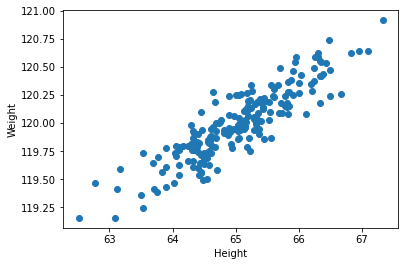

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data["height"], data["weight"]);
ax.set_xlabel("Height")
ax.set_ylabel("Weight");

Intuitively, if we had do draw a line through these points that explained the largest about of variation in our data, we'd draw it along the x=y diagonal. After that, the rest of the variation in the data can be described as the distance of each point from that diagonal. Those two directions will be the two principal components (PCs). 

Generally, if we have $n$ samples and $p$ features, we will be able to find $min(n-1, m)$ PCs. In this example, we have $m=2$ features, and can fully explain the data with 2 PCs. (Often in our genetic data, we will have many more features than samples. In that case the number of PCs will be limited by the sample size). The PCs are ordered according to how much variation they explain (PC1 explains the most variation, PC2 explains the next most, etc.).

## 2.3.3 Review of basic descriptive statistics

Let $X={x_{ij}}$ be our matrix of data. We have $m$ features ($i=1..m$) and $n$ samples ($j=1..n$). In the case of genetics data, $x_{ij}$ would give sample $j$'s genotype (0, 1, or 2) at SNP $i$. In our height and weight example, we have $m=2$ features (height and weight) and simulated $n=200$ samples. Note below we will use $X_i = {x_{i1}, x_{i2}, ... x_{in}}$ to refer to the vector of data across all samples for feature $i$. 

We will make use of the following statistics:

* **Mean**: $\overline{X_i} = \frac{1}{n} \sum_{j=1}^n x_{ij}$

* **Variance**: $\sigma^2(X_i) = \frac{1}{n-1} \sum_{j=1}^n (x_{ij}-\overline{X_i})^2$

* **Covariance**: $cov(X_i, X_k) = \frac{1}{n-1} \sum_{j=1}^n (x_{ij}-\overline{X_i})(x_{kj}-\overline{X_k})$

Note some special properties of the covariance:

1. The covariance of a vector with itself is equal to the variance: $cov(X_i, X_i) = \sigma^2(X_i)$
2. Covariance ie symmatric: $cov(X_i, X_k) = cov(X_k, X_i)$.

When performing PCA, we will be dealing primarily with the *covariance matrix*, often denoted as $cov(X)$ or $\Sigma$. (Note, covariance matrices will come up again in our trait prediction module). The covariance matrix is simply a matrix of the covariances between all pairs of features. So:

* $cov(X)$ has dimension $m \times m$
* Entry $i,k$ gives $cov(X_i, X_k)$
* Diagonal elements of the covariance matrix give $\sigma^2(X_1), \sigma^2(X_2), ... \sigma^2(X_m)$.
* Off diagonal elements give the covariance of each pair of features (e.g. SNPs).

Note, if the data is scaled such that the mean of each feature is 0, the covariance matrix can easily be computed as $cov(X)=XX^T/(n-1)$. We can also use the `np.cov` function to compute the covariance matrix. The cell below does this for our height and weight data.

In [31]:
# diagonals give Var(height) and Var(weight)
# Off-diagonals give Cov(height, weight)
cov = np.cov(data.transpose())
cov

array([[0.68217761, 0.23093475],
       [0.23093475, 0.09883179]])

## 2.3.4 Review of eigenvalues and eigenvectors

The key idea of PCA is going to be looking for structure in the covariance matrix. For this, we will use the concept of eigenvalues and eigenvectors from linear algebra. Note, there are full courses on linear algebra that will cover these concepts in detail. Here, we just attempt to understand these at a high level to give us intuition into what PCA is doing.

Given a square matrix $C$ (such as our $m$ by $m$ covariance matrix), which represents some linear transformation:

An **eigenvector** $\vec{v}$ of a matrix $C$ is a non-zero vector that does not change direction when $C$ is applied to it:

$$C\vec{v} = \lambda \vec{v}$$

where $\lambda$ is a scalar value known as the **eigenvalue** associated with eigenvector $\vec{v}$.

If $C$ is an $m\times m$ matrix, there are $m$ eigenvectors and corresponding eigenvalues:

$$ \vec{v_1}, \vec{v_2}, ... \vec{v_m}$$
$$ \lambda_1, \lambda_2, ... \lambda_m$$

These are ordered by the absolute value of the eigenvalues. Intuitively:
* The top eigenvectors are linear combinations of features that explain the most variation in our data.
* The corresponding eigenvalues tell us about how much variation is explained

Let's compute the eigenvalues and eigenvectors of our height and weight dataset:

In [32]:
eigvals, eigvecs = np.linalg.eig(cov)
print(eigvals)
print(eigvecs)

[0.7625315 0.0184779]
[[ 0.94446029 -0.32862557]
 [ 0.32862557  0.94446029]]


Let's draw the direction of the eigenvectors on our height vs. weight plot. These should go in the directions we intuitively thought should correspond to the two PCs.

See the cell below.

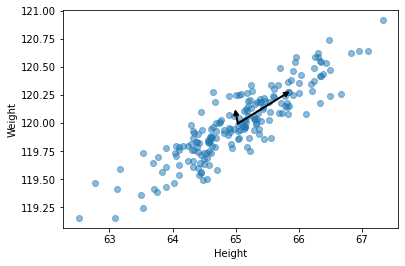

In [33]:
def DrawArrow(point1, point2, ax=None):
    """
    Draw a an arrow from point1 to point2.
    Takes an input a matplotlib ax object so
    you can add to an existing plot
    """
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', point2, point1, arrowprops=arrowprops)
    
# Make arrows start at the mean of each dimension
mean_vals = [np.mean(data["height"]), np.mean(data["weight"])]
point1 = mean_vals

pc1_point2 = mean_vals+eigvecs[:,0]*np.sqrt(eigvals[0])
pc2_point2 = mean_vals+eigvecs[:,1]*np.sqrt(eigvals[1])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data["height"], data["weight"], alpha=0.5);
DrawArrow(point1, pc1_point2, ax=ax)
DrawArrow(point1, pc2_point2, ax=ax)
ax.set_xlabel("Height")
ax.set_ylabel("Weight");

We note an interesting property - that the covariance matrix $C$ can now be decomposed in terms of its eigenvectors and eigenvalues. Let:

* $Q$ be an $m \times m$ matrix with columns $\vec{v_1}, \vec{v_2}, ... \vec{v_m}$
* $\Lambda$ be a diagonal $m \times m$ matrix with diagonal values $\lambda_1, \lambda_2, ... \lambda_m$ and off-diagonal values 0.

Then we can write:

$$ C = Q \Lambda Q^T$$

This is called the **eigendecomposition** of $C$. Let's just convince ourselves this is true on our height and weight data:

In [34]:
print(eigvecs.dot(np.diag(eigvals)).dot(eigvecs.transpose())) # Q*L*Q^T
print(cov) # cov

[[0.68217761 0.23093475]
 [0.23093475 0.09883179]]
[[0.68217761 0.23093475]
 [0.23093475 0.09883179]]


Finally, we can project our original data onto the PCs:

$$ X' = X^T Q$$

here $X'$ is an $n \times m$ matrix giving the projection of each sample along the $m$ PCs. Note e.g. the projection of sample 1 along PC 1 is the dot product of sample 1's data with eigenvector 1.

We can compute the projection of our height and weight data along the first two PCs, and plot the results. Note, since we only have two features, the first two PCs explains all the variation in our data, and so there is no longer any structure in the data.

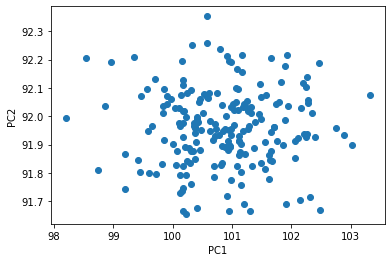

In [35]:
proj = data.dot(eigvecs)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(proj[0], proj[1])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2");

## 2.3.5 Performing PCA

Below are general steps for performing PCA, but we will describe variables in terms of SNP data.

* **Step 1**: Obtain a matrix of genotypes $D$, such that $D_{ij}$ gives the number of non-reference alleles for sample $j$ and SNP $i$. Our matrix will have dimensions $m \times n$ and all of the entries will be 0s, 1s, or 2s. Note in practice this matrix will need to be cleaned to remove missing data, very rare or invariant SNPs, and pruned to remove highly correlated SNPs. More on that later.

* **Step 2**: Center and scale each feature (SNP). Typically data for each SNP is scaled such that genotypes have mean 0 and variance 1. i.e. we take $\frac{X_i - \overline{X_i}}{\sigma({X_i})}$.

For a SNP with MAF $p_i$, this would come out to:

$$X_{ij} \in {\frac{-2p_i}{\sqrt{2p_i(1-p_i)}}, \frac{1-2p_i}{\sqrt{2p_i(1-p_i)}}, \frac{2-2p_i}{\sqrt{2p_i(1-p_i)}}}$$

(whereas our original data consisted of 0s, 1s, and 2s.)

* **Step 3**: Calculate a covariance matrix $Cov(X) = XX^T/n$. Note, since we scaled our data in step 2, all of the diagonal elements of this covariance matrix will be equal to 1.

* **Step 4**: Compute the eigendecomposition of $Cov(X)$ to get its eigenvectors and eigenvalues

* **Step 5**: Project the original data on the PCs: $X_{proj} = X^TQ$

* **Step 6**: Plot PCs to visualize. i.e. plot column 1 vs. column 2 of $X_{proj}$ to visualize the project of samples along the first two PCs.

## 2.3.6 The transpose trick

In our PCA description above, we took the covariance of $X$, which gave us an $m$ by $m$ matrix with the covariance between each pair of *SNPs*. In this case, we took the the eigenvectors $Q$ of $C=XX^T/n$, and $X^TQ$ gave us the projection of each sample along the PCs.

An alternative way we could have done this is by taking the covariance matrix of $X^T$ ($C=X^TX/n$). In this case, entries of the covariance matrix give the pairwise covariance between *samples*. This can actually be faster to compute, and the matrix forms the **genetic relatedness matrix** (GRM) we will use later on in the course when we talk about linear mixed models. In this case, the eigenvectors $V$ of $C$ themselves give the projection of each sample along the PCs.

Note these two methods:
1. Using the covariance matrix of $X$, and projecting samples using $X^TQ$
2. Using the covariance matrix of $X^T$, in which case the eigenvectors themselves already give the sample projections.

end up giving equivalent results. This is because of the following property:

If $v$ is an eigenvector of $XX^T$, then $X^Tv$ is an eigenvector of $X^TX$. This is known as the "transpose trick". See https://stats.stackexchange.com/questions/7111/how-to-perform-pca-for-data-of-very-high-dimensionality/7144#7144.


## 2.3.7 PCA on human data

In class you will perform PCA on the 1000 Genomes Project samples and visualize the first several PCs of the data. You should find:

* PC1 mostly separates African from non-African samples (AFR vs. others)
* PC2 separates East Eurasian from West Eurasian samples (EAS vs. EUR)
* Other groups will fall between the EUR, AFR, and EAS superpopulations. e.g. admixed African samples will fall bewteen African and European groups.

Some important notes on PCA interpretation:

* The SNPs themselves are largely similar across different populations. What differs is their frequencies.
* PCA reflects present-day populations, but major world populations have varied dramatically over the course of human history.
* While PCA on present day populations highlights “African”, “European” and “East Asian” these should not be interpreted as “pure” population groups. Nearly all present-day humans are in fact mixtures of previous major population groups. More on this in a couple weeks.

## References
[1] Race and Genetic Ancestry in Medicine — A Time for Reckoning with Racism. Borrell, et al. NEJM 2021.